In [50]:
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import pandas as pd
import yfinance as yf
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [33]:
full_data_one = yf.download("BTC-USD", start = "2023-01-01", end = datetime.date.today().strftime("%Y-%m-%d"), interval = "1d")
full_data_one#.reset_index(inplace = True)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-01,16547.914062,16630.439453,16521.234375,16625.080078,16625.080078,9244361700
2023-01-02,16625.509766,16759.343750,16572.228516,16688.470703,16688.470703,12097775227
2023-01-03,16688.847656,16760.447266,16622.371094,16679.857422,16679.857422,13903079207
2023-01-04,16680.205078,16964.585938,16667.763672,16863.238281,16863.238281,18421743322
2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328,16836.736328,13692758566
...,...,...,...,...,...,...
2024-02-26,51730.539062,54938.175781,50931.031250,54522.402344,54522.402344,34074411896
2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,57085.371094,49756832031
2024-02-28,57071.097656,63913.132812,56738.425781,62504.789062,62504.789062,83239156760


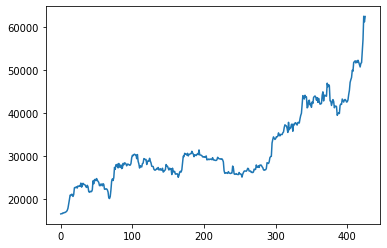

In [40]:
df2 = full_data_one.reset_index()['Close']
plt.plot(df2)

In [35]:
# plt.figure(figsize = (18,9))
# plt.plot(range(full_data_one.shape[0]), (full_data_one['Low'] + full_data_one['High']) / 2.0)
# plt.xlabel('Date', fontsize = 18)
# plt.ylabel('Mid Price', fontsize = 18)
# plt.show()

In [31]:
full_data_one.shape

(426, 7)

In [69]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1, 1))
df2.shape

(426, 1)

In [75]:
train_size = int(len(df2) * 0.65)
test_size = len(df2) - train_size
train_data, test_data = df2[0:train_size, :], df2[train_size:len(df2), :1]

print(len(train_data))
print(len(test_data))

276
150


In [89]:
def create_dataset(dataset, time_step = 1):
    
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        # i to i+time_step, first column
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
                    
    return np.array(dataX), np.array(dataY)

In [91]:
time_step = 100

X_train, Y_train =  create_dataset(train_data, time_step)
X_test, Y_test =  create_dataset(test_data, time_step)

print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))

175 175
49 49


In [51]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

2024-03-02 22:02:44.999085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [107]:
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 30, batch_size = 64,verbose = 1)

Epoch 1/30
3/3 [==============================] - 1s 169ms/step - loss: 5.4410e-04 - val_loss: 0.0588
Epoch 2/30
3/3 [==============================] - 0s 173ms/step - loss: 5.7759e-04 - val_loss: 0.0773
Epoch 3/30
3/3 [==============================] - 0s 167ms/step - loss: 5.6352e-04 - val_loss: 0.0589
Epoch 4/30
3/3 [==============================] - 0s 172ms/step - loss: 6.1626e-04 - val_loss: 0.0744
Epoch 5/30
3/3 [==============================] - 0s 157ms/step - loss: 5.6618e-04 - val_loss: 0.0649
Epoch 6/30
3/3 [==============================] - 0s 160ms/step - loss: 5.6443e-04 - val_loss: 0.0682
Epoch 7/30
3/3 [==============================] - 0s 164ms/step - loss: 5.4184e-04 - val_loss: 0.0644
Epoch 8/30
3/3 [==============================] - 0s 156ms/step - loss: 5.5225e-04 - val_loss: 0.0704
Epoch 9/30
3/3 [==============================] - 0s 160ms/step - loss: 5.4850e-04 - val_loss: 0.0651
Epoch 10/30
3/3 [==============================] - 0s 160ms/step - loss: 5.5191e-0

In [108]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(len(train_predict))
print(len(test_predict))

2/2 [==============================] - 0s 24ms/step
175
49


In [109]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [110]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

0.02305711421361469
0.23988882165733594


In [127]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict) + look_back,:] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back) * 2 + 1 : len(df2) - 1,:] = test_predict

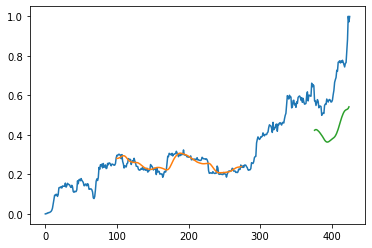

In [128]:
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()